# Compare Accuracy of doc2vec vs dictionary

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import re
from wordfreq import top_n_list
import numpy as np
from nltk.corpus import stopwords
import requests
import requests_random_user_agent
from tqdm.notebook import tqdm
from nltk.stem import PorterStemmer
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
import dask
dask.config.set(scheduler="processes")
from tqdm.dask import TqdmCallback
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import glob
from gensim.test.utils import datapath
import logging
import random
from random import sample
random.seed(1)
from fpdf import FPDF
from IPython.display import clear_output
import time

In [3]:
import os
print(os.getcwd())
os.chdir('..') 
print(os.getcwd())

/Users/danielceleny/Documents/Cyberisk_price/code/tests
/Users/danielceleny/Documents/Cyberisk_price/code


In [6]:
#import functions from functions.py
from function_definitions import *

Cybersecurity related:
Number of sentences: 68
Number of paragraphs: 34
Average paragraph length: 37.970588235294116


Not cybersecurity related:
Number of sentences: 64
Number of paragraphs: 34
Average paragraph length: 37.088235294117645


Vectorizing Tactics:   0%|          | 0/14 [00:00<?, ?it/s]

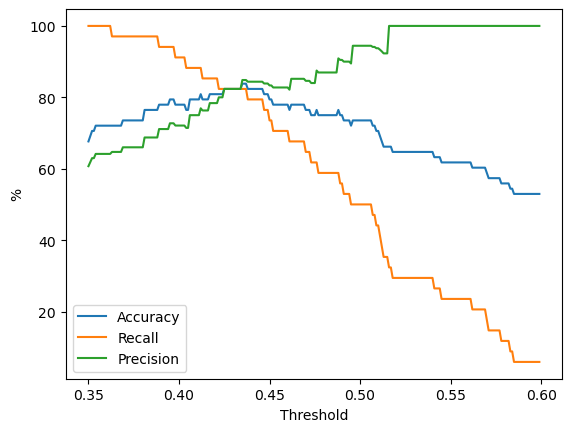

Maximum accuracy: 83.82352941176471
Maximum precision: 100.0


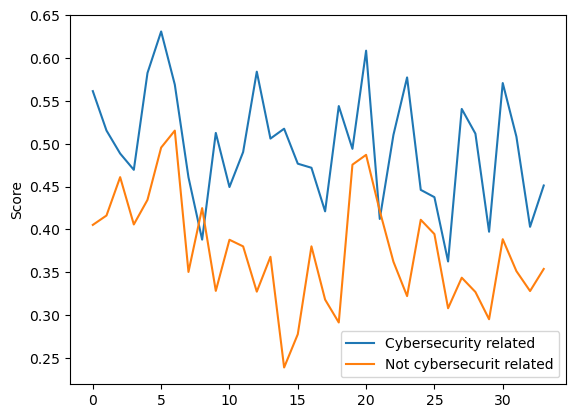

Mean cyber = 0.49630852399607217
Mean not cyber = 0.3758987471774887


In [6]:
# read in the data
data = pd.read_excel('../data/labelled_sentences.xlsx')

#print token stats
print('Cybersecurity related:')
tokens = get_tokens(' '.join(data['Cybersec related'].dropna().values), ticker = None, raw = False, merge = False, sentences = True)
print(f'Number of sentences: {len(tokens)}')
new_tokens,merge_list = merge_sentences(tokens, ret_merge_list = True) #messes up "tokens"
data['Cybersecurity related merge list'] = merge_list
print(f'Number of paragraphs: {len(new_tokens)}')
print(f'Average paragraph length: {np.mean([len(t) for t in new_tokens])}')

print('\n')
print('Not cybersecurity related:')
tokens = get_tokens(' '.join(data['Not cybersec related'].dropna().values), ticker = None, raw = False, merge = False, sentences = True)
print(f'Number of sentences: {len(tokens)}')
new_tokens,merge_list = merge_sentences(tokens, ret_merge_list = True) #messes up "tokens"
merge_list += [np.nan]*(len(data)-len(merge_list))
data['Not cybersecurity related merge list'] = merge_list
print(f'Number of paragraphs: {len(new_tokens)}')
print(f'Average paragraph length: {np.mean([len(t) for t in new_tokens])}')

#load the doc2vec model
model_ = 'model_dbow_v200_e50_w15'
#load the previously saved model
path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/'+model_)
model = gensim.models.doc2vec.Doc2Vec.load(path)

#get vectors of MITRE Tactics
tactic_types = glob.glob('../data/MITRE_ATT&CK/descriptions/tactics*')
vec_tac = []
type_table = []
for type_ in tqdm(tactic_types, desc = 'Vectorizing Tactics', leave = False):
    tactics = pd.read_csv(type_, index_col = [0,1])
    name = re.findall('tactics_([^\.]+)',type_)[0]
    for sub_technique,tactic in tactics.droplevel('technique').itertuples():
        tokens = get_tokens(tactic, raw = False, merge = False, sentences = False)[0]
        vec_tac.append(get_vect(model, tokens, '{}__{}'.format(name,sub_technique)))
        type_table.append(name)
type_table = np.array(type_table)

#tokenize and compute cybersecurity related similarity
cybersec_tokens = get_tokens(' '.join(data['Cybersec related'].dropna().values), ticker = None, raw = False, merge = True, sentences = True)
#get vectors of cybersec related paragraphs
cybersec_vects = []
for i,paragraph in enumerate(cybersec_tokens):
    cybersec_vects.append(get_vect(model, paragraph, 'test_cyber__{}'.format(i)))

#compute the similarity for all vectors
sim = []
for v in cybersec_vects:
    sim.append(fast_sim(v, vec_tac))
scores = np.max(sim, axis = 1) #consider the maximum similarity for each paragraph

#tokenize and compute not cybersecurity related similarity
not_cybersec_tokens = get_tokens(' '.join(data['Not cybersec related'].dropna().values), ticker = None, raw = False, merge = True, sentences = True)
#get vectors of not cybersec related paragraphs
not_cybersec_vects = []
for i,paragraph in enumerate(not_cybersec_tokens):
    not_cybersec_vects.append(get_vect(model, paragraph, 'test_notcyber__{}'.format(i)))

#compute the similarity for all vectors
sim = []
for v in not_cybersec_vects:
    sim.append(fast_sim(v, vec_tac))
scores_ = np.max(sim, axis = 1) #consider the maximum similarity for each paragraph

#compute accuracy, recall and precision
accuracy = []
recall = []
precision = []
for sep in np.arange(0.35,0.60,0.001):
    TP = len(scores[scores > sep])
    TN = len(scores_[scores_ < sep])
    FP = len(scores_[scores_ > sep])
    FN = len(scores[scores < sep])
    accuracy.append(((TP+TN)/(TP+TN+FP+FN))*100)
    recall.append((TP/(TP+FN))*100)
    precision.append((TP/(TP+FP))*100)
    
#plots
plt.plot(np.arange(0.35,0.60,0.001),accuracy)
plt.plot(np.arange(0.35,0.60,0.001),recall)
plt.plot(np.arange(0.35,0.60,0.001),precision)
plt.legend(['Accuracy','Recall','Precision'])
plt.ylabel('%')
plt.xlabel('Threshold')
plt.show()
print(f'Maximum accuracy: {np.max(accuracy)}')
print(f'Maximum precision: {np.max(precision)}')

plt.plot(scores)
plt.plot(scores_)
plt.legend(['Cybersecurity related','Not cybersecurit related'])
plt.ylabel('Score')
plt.show()
print(f'Mean cyber = {np.mean(scores)}')
print(f'Mean not cyber = {np.mean(scores_)}')

## Using old MITRE

Cybersecurity related:
Number of sentences: 68
Number of paragraphs: 34
Average paragraph length: 37.970588235294116


Not cybersecurity related:
Number of sentences: 64
Number of paragraphs: 34
Average paragraph length: 37.088235294117645


Vectorizing Tactics:   0%|          | 0/14 [00:00<?, ?it/s]

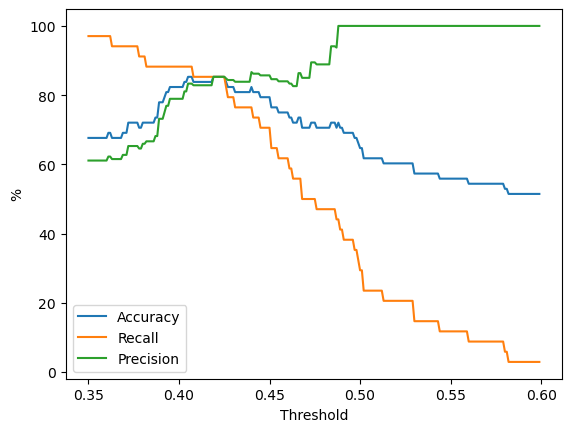

Maximum accuracy: 85.29411764705883
Maximum precision: 100.0


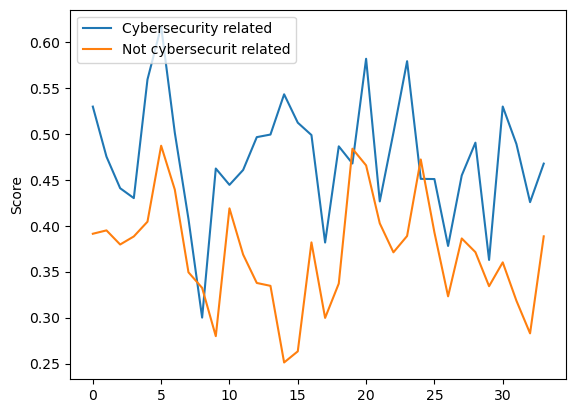

Mean cyber = 0.47353462036690247
Mean not cyber = 0.37001467074554706


In [7]:
# read in the data
data = pd.read_excel('../data/labelled_sentences.xlsx')

#print token stats
print('Cybersecurity related:')
tokens = get_tokens(' '.join(data['Cybersec related'].dropna().values), ticker = None, raw = False, merge = False, sentences = True)
print(f'Number of sentences: {len(tokens)}')
new_tokens,merge_list = merge_sentences(tokens, ret_merge_list = True) #messes up "tokens"
data['Cybersecurity related merge list'] = merge_list
print(f'Number of paragraphs: {len(new_tokens)}')
print(f'Average paragraph length: {np.mean([len(t) for t in new_tokens])}')

print('\n')
print('Not cybersecurity related:')
tokens = get_tokens(' '.join(data['Not cybersec related'].dropna().values), ticker = None, raw = False, merge = False, sentences = True)
print(f'Number of sentences: {len(tokens)}')
new_tokens,merge_list = merge_sentences(tokens, ret_merge_list = True) #messes up "tokens"
merge_list += [np.nan]*(len(data)-len(merge_list))
data['Not cybersecurity related merge list'] = merge_list
print(f'Number of paragraphs: {len(new_tokens)}')
print(f'Average paragraph length: {np.mean([len(t) for t in new_tokens])}')

#load the doc2vec model
model_ = 'model_dbow_v200_e50_w15'
#load the previously saved model
path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/old_Doc2vec/'+model_)
model = gensim.models.doc2vec.Doc2Vec.load(path)

#get vectors of MITRE Tactics
tactic_types = glob.glob('../data/MITRE_ATT&CK/descriptions/tactics*')
vec_tac = []
type_table = []
for type_ in tqdm(tactic_types, desc = 'Vectorizing Tactics', leave = False):
    tactics = pd.read_csv(type_, index_col = [0,1])
    name = re.findall('tactics_([^\.]+)',type_)[0]
    for sub_technique,tactic in tactics.droplevel('technique').itertuples():
        tokens = get_tokens(tactic, raw = False, merge = False, sentences = False)[0]
        vec_tac.append(get_vect(model, tokens, '{}__{}'.format(name,sub_technique)))
        type_table.append(name)
type_table = np.array(type_table)

#tokenize and compute cybersecurity related similarity
cybersec_tokens = get_tokens(' '.join(data['Cybersec related'].dropna().values), ticker = None, raw = False, merge = True, sentences = True)
#get vectors of cybersec related paragraphs
cybersec_vects = []
for i,paragraph in enumerate(cybersec_tokens):
    cybersec_vects.append(get_vect(model, paragraph, 'test_cyber__{}'.format(i)))

#compute the similarity for all vectors
sim = []
for v in cybersec_vects:
    sim.append(fast_sim(v, vec_tac))
scores = np.max(sim, axis = 1) #consider the maximum similarity for each paragraph

#tokenize and compute not cybersecurity related similarity
not_cybersec_tokens = get_tokens(' '.join(data['Not cybersec related'].dropna().values), ticker = None, raw = False, merge = True, sentences = True)
#get vectors of not cybersec related paragraphs
not_cybersec_vects = []
for i,paragraph in enumerate(not_cybersec_tokens):
    not_cybersec_vects.append(get_vect(model, paragraph, 'test_notcyber__{}'.format(i)))

#compute the similarity for all vectors
sim = []
for v in not_cybersec_vects:
    sim.append(fast_sim(v, vec_tac))
scores_ = np.max(sim, axis = 1) #consider the maximum similarity for each paragraph

#compute accuracy, recall and precision
accuracy = []
recall = []
precision = []
for sep in np.arange(0.35,0.60,0.001):
    TP = len(scores[scores > sep])
    TN = len(scores_[scores_ < sep])
    FP = len(scores_[scores_ > sep])
    FN = len(scores[scores < sep])
    accuracy.append(((TP+TN)/(TP+TN+FP+FN))*100)
    recall.append((TP/(TP+FN))*100)
    precision.append((TP/(TP+FP))*100)
    
#plots
plt.plot(np.arange(0.35,0.60,0.001),accuracy)
plt.plot(np.arange(0.35,0.60,0.001),recall)
plt.plot(np.arange(0.35,0.60,0.001),precision)
plt.legend(['Accuracy','Recall','Precision'])
plt.ylabel('%')
plt.xlabel('Threshold')
plt.show()
print(f'Maximum accuracy: {np.max(accuracy)}')
print(f'Maximum precision: {np.max(precision)}')

plt.plot(scores)
plt.plot(scores_)
plt.legend(['Cybersecurity related','Not cybersecurit related'])
plt.ylabel('Score')
plt.show()
print(f'Mean cyber = {np.mean(scores)}')
print(f'Mean not cyber = {np.mean(scores_)}')